Taken from https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai

-----------------------------------------
# Data visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


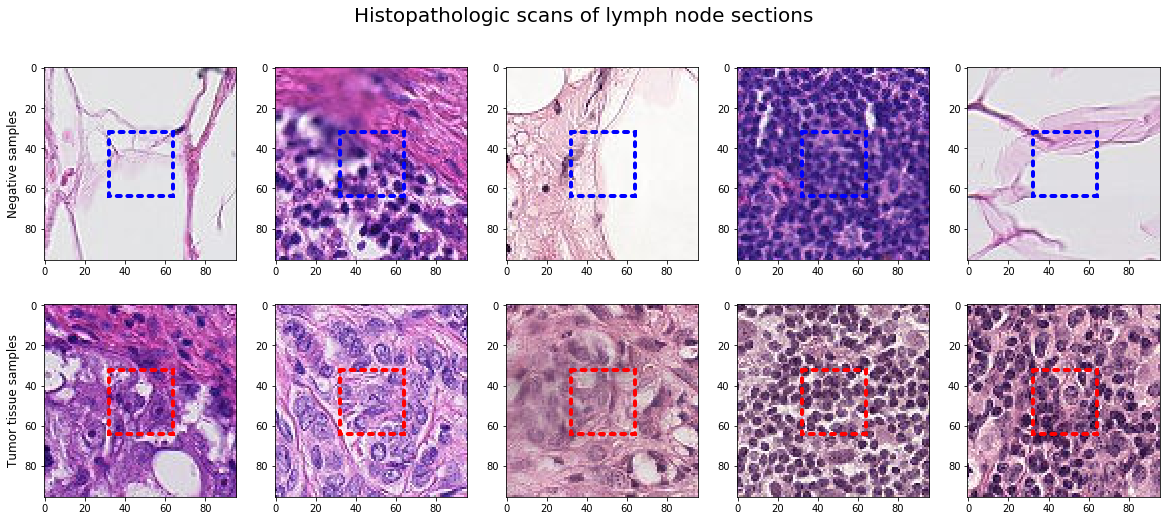

In [96]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import cv2

from src.imports import *
from src.constants import *
from src.utils import *
from src.preprocessing import *
from src.models import *

data = pd.read_csv(path_to_train_labels)
# # quick look at the label stats
data['label'].value_counts()

shuffled_data = shuffle(data)
printRandomImages(shuffled_data)

### Preprocessing and augmentation
There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions. 

**The augmentations we can use for this type of data:**
- random rotation
- random crop
- random flip (horizontal and vertical both)
- random lighting
- random zoom (not implemented here)
- Gaussian blur (not implemented here)

We will use OpenCV with image operations because in my experience, OpenCV is a lot faster than *PIL* or *scikit-image*.

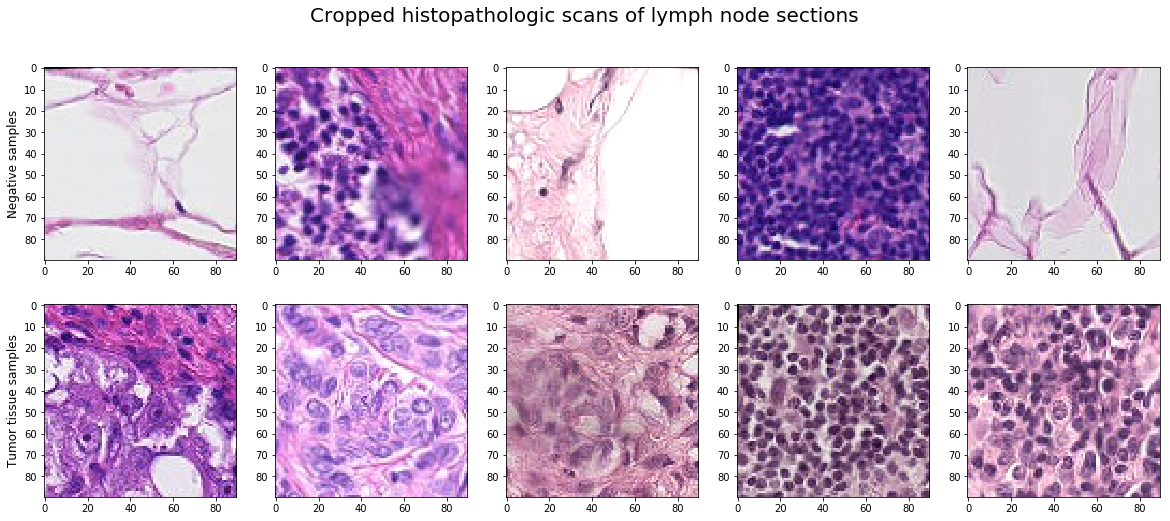

In [97]:
printRandomCroppedImages(shuffled_data)

### Compute image statistics
**Do not use augmentation here!**

Calculating statistics will give channel averages of [0.702447, 0.546243, 0.696453],
and std's of [0.238893, 0.282094, 0.216251].

While we are calculating statistics, we can check if there are images that have a very low maximum pixel intensity (almost totally black) or very high minimum pixel intensity (almost totally white). These kind of images could be caused by bad exposure or cropping to an empty area. In case of an empty area, the image would not be an outlier but equally valid negative sample.

We find that there is at least one very dark and 6 very bright images.

In [98]:
# no necessary to use it - juts 7 outliers
# idxs = findOutlierImages(shuffled_data)
# printOutlierStatistics(shuffled_data, idxs[0], idxs[1])

# Baseline model (Fastai v1)
In ML production pipeline, it is a good idea to start with a relatively simple model, sort of a minimum viable product (MVP) or a baseline. With MVP, we can very quickly see if there are some unexpected problems like bad data quality that will make any further investments into the model tuning not worth it.

### Prepare the data and split train
Prepare the data and split train
Split train data to 90% training and 10% validation parts. We want to maintain equal ratios of negative/positive (60/40) in both, training and test splits. This is not so crucial here as both labels are almost equally represented but in case we had a rare class, random split could cause severe underrepresentation or in worst case, leave all rare classes out of one split.

We will use [**Fast.ai V1**](https://docs.fast.ai/) software library that is built on [PyTorch](https://pytorch.org/). What I like about Fast.ai is that it includes "out of the box" support for many recent advancements in deep learning research. If you want to use the 0.7 version of Fast.ai, see commit version 9 of this kernel.

I highly recommend the [Fastai: practical deep learning course for coders, v3](https://course.fast.ai/).

I want to thank [Martijn](https://www.kaggle.com/etinuz) for sharing his examples of Fastai v1 training and visualization! They were helpful when converting this kernel from Fastai v0.7 to v1.0.

### What kind of model architecture suits the problem best?

Here we will be using a pretrained convnet model and transfer learning to adjust the weights to our data. Going for a deeper model architecture will start overfitting faster.

For differenet pretrained model architectures, check [Fast.ai vision models](https://docs.fast.ai/vision.models.html) and [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

We load the images to an ImageDataBunch for the training. This fastai's data object is easily customized for loading images using our own `readCroppedImage` function. We just need to subclass ImageList. 
[Data API docs](https://docs.fast.ai/data_block.html)

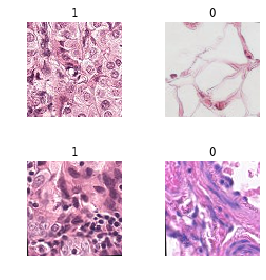

In [99]:
imgDataBunch = getDataBunchForFastAI(data)
# check that the imgDataBunch is loading our images ok
imgDataBunch.show_batch(rows=2, figsize=(4,4))

### Training
We define a convnet learner object where we set the model architecture and our data bunch.
[`create_cnn` docs.fast.ai](https://docs.fast.ai/vision.learner.html#create_cnn)

In [100]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
learner = getLearner(imgDataBunch)

/Users/yevhenp/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


### 1cycle policy
We will use the one cycle policy proposed by Leslie Smith, [arXiv, April 2018](https://arxiv.org/abs/1803.09820). The policy brings more disciplined approach for selecting hyperparameters such as learning rate and weight decay.** This can potentially save us a lot of time from training with suboptimal hyperparameters.** In addititon, Fastai library has implemented a training function for one cycle policy that we can use with only a few lines of code.

Sylvian Gugger wrote a very clear [explanation](https://sgugger.github.io/the-1cycle-policy.html) of Leslie's proposal that I recommend for reading.

First, we find the optimal `learning rate` and `weight decay` values. The optimal lr is just before the base of the loss and before the start of divergence. It is important that the loss is still descending where we select the learning rate.

As for the `weight decay` that is the L2 penalty of the optimizer, Leslie proposes to select the largest one that will still let us train at a high learning rate so we do a small grid search with 1e-2, 1e-4 and 1e-6 weight decays.

In [101]:
res = run_one_cycle_policy(learner, imgDataBunch)

lrs = res[0]
losses = res[1]
wds = res[2]

learner = getLearner(imgDataBunch) #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


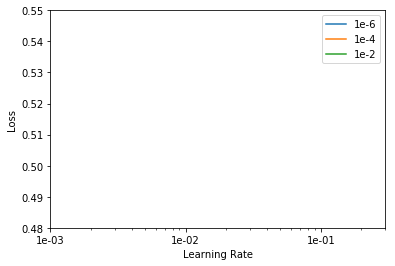

In [108]:
# Plot weight decays
plotWeightDecays(lrs, losses, wds)

**We want to select the largest weight decay that gets to a low loss and has the highest learning rate before shooting up.**
Out of the tested WD's, 1e-4 seems like the largest WD that allow us to train with maximal learning rate. *Note that the plot above may differ between runs as we use a random subset of data for computations.*

> Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and deeper architectures seem to require smaller values. 
[Leslie  Smith](https://arxiv.org/pdf/1803.09820.pdf)

We can select the `learning rate` around 2e-2 where it is close to the bottom but still descending.

Next, we train only the heads while keeping the rest of the model frozen. Otherwise, the random initialization of the head weights could harm the relatively well-performing pre-trained weights of the model. After the heads have adjusted and the model somewhat works, we can continue to train all the weights.

In [109]:
max_lr = 2e-2
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

We can see that the learning rate starts from lower and reaches the `max_lr` in the middle. Then it slows back down near the end. The idea is that we start with a low warm-up learning rate and gradually increase it to high. The higher rate is having a regularizing effect as it won't allow the model to settle for sharp and narrow local minima but pushes for wider and more stable one.

In the middle of our cycle, we start to lower the learning rate as we are hopefully in a good stable area. This means that we start to look for the minima within that area.

## Is the model learning?
Our model should have already learned something and if it hasn't, there's probably something wrong with our code or with the data. 

In [ ]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

We can see from the plotted losses that there is a small rise after the initial drop which is caused by the increasing learning rate of the first half cycle. The losses are temporarily rising when `max_lr` drives the model out of local minima but this will pay off in the end when the learning rates are decreased.

In [ ]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

**Confusion matrix** can help us understand the ratio of false negatives and positives and it's a fast way looking at our model's performance. This is a simple table that shows the counts in a way of actual label vs. predicted label. Here we can see that the model has learned to distinguish tumor and negative sample and it's already performing well. However, we will continue training further to improve from here.

In [ ]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1')

# Finetuning the baseline model
Next, we can unfreeze all the trainable parameters from the model and continue its training. 

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

In [ ]:
# load the baseline model
learner.load(MODEL_PATH + '_stage1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

In [ ]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

In [ ]:
learner.recorder.plot_losses()

We can see that the validation performance has separated from the training performance a bit in the end of the cycle. This means that our model has started overfitting during the small learning rates. Now, if we would train further, the model would only memorize features from the training set and the validation set performance would rise. This is a good place to stop.  

In [ ]:
# lets take a second look at the confusion matrix. See if how much we improved.
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [ ]:
# Save the finetuned model
learner.save(MODEL_PATH + '_stage2')

In [ ]:
# if the model was better before finetuning, uncomment this to load the previous stage
#learner.load(MODEL_PATH + '_stage1')

-------------------------
# Validation and analysis
Now the training is done.

### How good does the model perform technically?

We can only get metrics from our validation set, and the final test metrics will be most likely a bit different.

In [ ]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

### How good is the model in terms of project requirements?
It is a good idea to look at examples of images from:

- Random samples
    - Some random predictions
- The most incorrectly labeled
    - What our model predicts wrong with very high probability.
- The most correctly labeled
    - What our model is most confident of and gets right.
    
This visualization is a good way of understanding what are the images the model struggles with. It might also reveal something about the dataset such as bad quality data.

In [ ]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
# from random import randint


In [ ]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Negative','Tumor'])

### Gradient-weighted Class Activation Mapping (Grad-CAM)
[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

This method produces a coarse localization map highlighting the areas that the model considers important for the classification decision. The visual explanation gives transparency to the model making it easier to notice if it has learned the wrong things. For example, if we would train a dog breed classifier and all of our images of a certain dog breed would have been taken in a dog show competition. There is a good chance that the model would learn to recognize the competition surroundings instead of doggy features with that breed. Visualizing the localization map would reveal that, and we could focus on getting more diverse data of that breed.  

In [ ]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [ ]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
plot_heatmap_overview(interp, ['Negative','Tumor'])

This shows the activation maps of the predicted category so if the label is ```tumor```, the visualization shows all the places where the model thinks the tumor patterns are.

### ROC curve and AUC
Remember, AUC is the metric that is used for evaluating submissions. We can calculate it here for ou validation set but it will most likely differ from the final score.

In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

----------------

# Submit predictions
### TTA
To evaluate the model, we run inference on all test images. As we have test time augmentation, our results will probably improve if we do predictions multiple times per image and average out the results. 

In [ ]:
# make sure we have the best performing model stage loaded
learner.load(MODEL_PATH + '_stage2')

# Fastai has a function for this but we don't want the additional augmentations it does (our image loader has augmentations) so we just use the get_preds
#preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)

# We do a fair number of iterations to cover different combinations of flips and rotations.
# The predictions are then averaged.
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

In [ ]:
# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

### Submit the model for evaluation
We need to submit the tumor probability for each test sample in this competition. The probability ranges from 0 to 1.

In [ ]:
# get test id's from the sample_submission.csv and keep their original order
SAMPLE_SUB = path_to_sample_submission
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in tumor_preds]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['///'+ test_path + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [ ]:
# This is what the first 10 items of submission look like
df_sub.head(10)

--------------------------------------------------------------

# Deploy (example)
Now that we have a working model. We could deploy this for inference to another machine, a web server for example.
For this, we need our saved model, and then we need to export the  DataBunch.

**Note**. I haven't tried these so I cannot guarantee these will work straight away. You may need to do some debugging. [Official documentation](https://docs.fast.ai/tutorial.inference.html).

In [ ]:
# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
imgDataBunch.export(fname='./export.pkl')

**On a new machine**
We need to create an empty DataBunch and load it to a learner.

In [ ]:
######## RUN THIS ON A NEW MACHINE ##########
#from fastai.vision import * # fastai 1.0
#from fastai import *
#from torchvision.models import *
#arch = densenet169       # specify model architecture
#MODEL_PATH = str(arch).split()[1] + '_stage2'
#empty_data = ImageDataBunch.load_empty('./') #this will look for a file named export.pkl in the specified path
#learner = create_cnn(empty_data, arch).load(MODEL_PATH)

In [ ]:
## And then we are ready to do predictions
import cv2
sz = 68

# This function will convert image to the prediction format
def imageToTensorImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    # crop to center to the correct size and convert from 0-255 range to 0-1 range
    H,W,C = rgb_img.shape
    rgb_img = rgb_img[(H-sz)//2:(sz +(H-sz)//2),(H-sz)//2:(sz +(H-sz)//2),:] / 256
    return vision.Image(px=pil2tensor(rgb_img, np.float32))

img = imageToTensorImage(test_path + '0eb051700fb6b1bf96188f36c8e4889598c6a157.tif')

## predict and visualize
img.show(y=learner.predict(img)[0])
classes = ['negative', 'tumor']
print('This is a ' + classes[int(learner.predict(img)[0])] + ' tissue image.')